## Helio Inaba - CQF June 2023 Final Project 
## Optimal Hedging with Advanced Delta Modelling

### Part I: Volatility Arb with improved GBM and Monte-Carlo ###

1. Consider improvements to GBM asset evolution (Euler-Maruyana/Milstein schemes). <br> Optionally, can consider modelling asset with jumps, eg, Merton jump diffusion, without going into stochastic volatility, eg Heston-Nandi. <br> Variance Gamma is also relevant but suited for single-name assets with extreme movements.
 - consider MC variance reduction techniques, such as antithetic variates; <br>
 - best practice is low discrepancy sequences, eg Sobol with the Brownian bridge.


2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is
the impact of time-dependent Gamma $ \Gamma_{t} $? What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import scipy
from scipy.stats import norm

from datetime import datetime
import os

#pd.set_option('display.max_columns', None)
pd.reset_option('^display.', silent=True)


### Brownian Bridge

In [160]:
def fill_bridge(a, b, delta_t, z=None):

    
    if z == None:
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z
    

def brownian_bridge(w0, w1, n):

    df_wt = pd.DataFrame(columns=['W_t'], index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    df_wt.iloc[0] = w0
    df_wt.iloc[-1] = w1

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):

            df_wt.loc[j] = fill_bridge(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1))

    return df_wt



Average of dW_t: 0.0
Variance of dW_t: 1.0


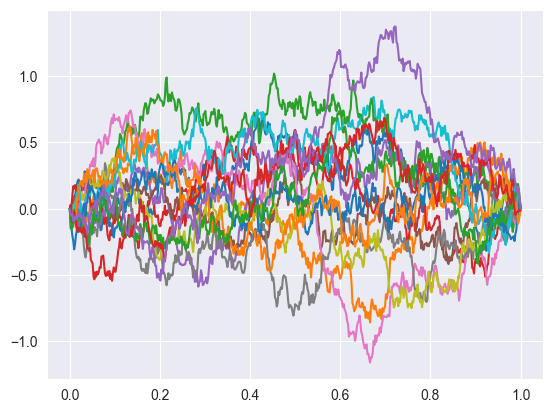

In [173]:
n=12

df_wt = brownian_bridge(w0=0.0, w1=0.0, n=n)

print(f'Average of dW_t: {np.round(np.mean(df_wt.diff()), 3)}')
print(f'Variance of dW_t: {np.round(np.var(df_wt.W_t.diff())*(2**n), 3)}')

for i in range(0, 15):
    plt.plot(brownian_bridge(w0=0, w1=0.0, n=9))

In [174]:
(2**n)*df_wt.diff().var()

W_t    1.000491
dtype: object

#### Defining Constants

In [4]:
S = 50
K = 55
sigma = .30
r = .1
T = 360/360

In [ ]:
def antithetic_variables(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices_plus = np.zeros((n_simulations, n_periods+1))
    prices_plus[:,0] = s0

    prices_minus = np.zeros((n_simulations, n_periods+1))
    prices_minus[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))
    z_minus = -z

    wiener_matrix = np.matmul(A_matrix, z_minus)
    wiener_matrix = np.transpose(wiener_matrix)

    wiener_matrix_minus = np.matmul(A_matrix, z)
    wiener_matrix_minus = np.transpose(wiener_matrix_minus)

    prices_plus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)
    prices_minus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix_minus)


    prices_plus = pd.DataFrame(np.transpose(prices_plus))
    prices_minus = pd.DataFrame(np.transpose(prices_minus))
    
    prices_plus.index.name = 'period'
    prices_plus.index.columns = 'simulation'

    prices_minus.index.name = 'period'
    prices_minus.index.columns = 'simulation'

    return prices_plus, prices_minus

In [ ]:
def milstein(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_simulations, n_periods+1))
    prices[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    prices[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)

    prices = pd.DataFrame(np.transpose(prices))
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


In [13]:
def sobol_prices(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_periods, n_simulations))
    prices[0] = s0

    sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
    sample = sampler.random_base2(int(np.log2(n_simulations)))
    sample = np.transpose(sample)
    norm_sample = norm.ppf(sample)

    for i in range(1, n_periods):

        prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + (sigma*np.sqrt(expiry_T/n_periods))*norm_sample[i])

    prices = pd.DataFrame(prices)
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

In [18]:
n_simulations=2**12 #4096
n_periods=2**9 #512


In [60]:

prices = np.zeros((n_periods+1, n_simulations))
prices[0] = 1

sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
sample = sampler.random_base2(int(np.log2(n_simulations)))
sample = np.transpose(sample)
norm_sample = norm.ppf(sample)

prices[-1,:] = np.exp(r*T-.5*(sigma**2))*np.exp(sigma*np.sqrt(1)*pd.DataFrame(norm_sample).iloc[0])

final_prices = (s0*np.exp(r*T-.5*(sigma**2))*np.exp(sigma*np.sqrt(1)*pd.DataFrame(norm_sample).iloc[0]))
payoff = np.maximum(final_prices-K,0)
np.exp(-r*(T))*np.mean(payoff)-bs_price

0.005046062658109918

(array([ 10.,  68., 213., 406., 555., 608., 570., 479., 370., 271., 189.,
        127.,  84.,  54.,  35.,  21.,  14.,   8.,   6.,   3.,   2.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.33982695, 0.45329545, 0.56676396, 0.68023246, 0.79370096,
        0.90716947, 1.02063797, 1.13410647, 1.24757497, 1.36104348,
        1.47451198, 1.58798048, 1.70144899, 1.81491749, 1.92838599,
        2.0418545 , 2.155323  , 2.2687915 , 2.38226   , 2.49572851,
        2.60919701, 2.72266551, 2.83613402, 2.94960252, 3.06307102,
        3.17653952, 3.29000803, 3.40347653, 3.51694503, 3.63041354,
        3.74388204]),
 <BarContainer object of 30 artists>)

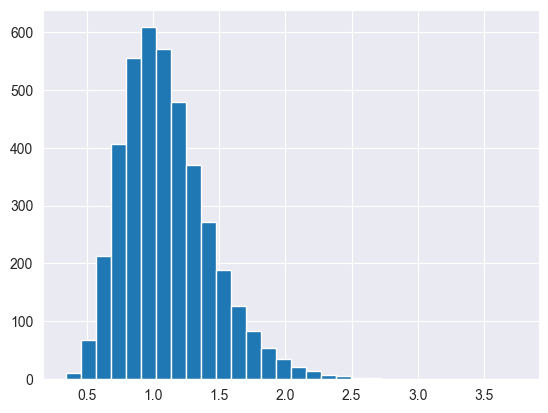

In [62]:
plt.hist(pd.DataFrame(prices).iloc[512],bins=30)

In [280]:

def sobol_prices(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    n = int(np.log2(n_periods))

    compounding_array = np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods))

    W_t = np.empty((n_periods+1, n_simulations))
    W_t[:] = np.nan
    W_t[0] = 0.0

    prices = np.zeros((n_periods+1, n_simulations))
    prices = pd.DataFrame(prices, index=np.arange(0, 1+1/(2**n), 1/(2**n)))
    prices.iloc[0] = s0

    sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
    sample = sampler.random_base2(int(np.log2(n_simulations)))
    sample = np.transpose(sample)
    norm_sample = norm.ppf(sample)

    k = 0
    W_t[-1,:] = norm_sample[k,:]

    df_wt = pd.DataFrame(W_t, index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):
            k+=1
            df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1), z=norm_sample[k,:])
            
    prices.iloc[1:] = s0*(np.exp(sigma*df_wt.iloc[1:,].values).T*compounding_array).T
    prices.index = prices.index*expiry_T

    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

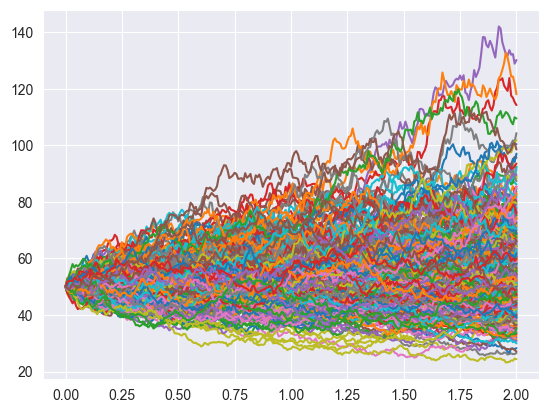

In [284]:
plt.plot(sobol_prices(s0=S, expiry_T=2, sigma=sigma, return_rate=r, n_periods=2**8, n_simulations=2**8))

In [275]:
n_simulations=2**10 #4096
n_periods=2**5 #512

n = int(np.log2(n_periods))

compounding_array = np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods))

W_t = np.empty((n_periods+1, n_simulations))
W_t[:] = np.nan
W_t[0] = 0.0

prices = np.zeros((n_periods+1, n_simulations))
prices = pd.DataFrame(prices, index=np.arange(0, 1+1/(2**n), 1/(2**n)))
prices.iloc[0] = s0


sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
sample = sampler.random_base2(int(np.log2(n_simulations)))
sample = np.transpose(sample)
norm_sample = norm.ppf(sample)

k = 0
W_t[-1,:] = norm_sample[k,:]

df_wt = pd.DataFrame(W_t, index=np.arange(0, 1+1/(2**n), 1/(2**n)))

for i in range(1, n+1):
    
    for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):
        k+=1
        df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1), z=norm_sample[k,:])
        
prices.iloc[1:] = s0*(np.exp(sigma*df_wt.iloc[1:,].values).T*compounding_array).T
prices.index = prices.index*T

prices.index.name = 'period'
prices.index.columns = 'simulation'


payoff = np.maximum(prices.iloc[-1:].values-K,0)
np.exp(-r*(T))*np.mean(payoff)-bs_price

-0.008683719767350162

In [276]:
prices

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
period,,,,,,,,,,,,,,,,,,,,,
0.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
0.03125,55.249961,46.265586,48.862305,51.332033,47.883529,50.014310,49.382421,52.592532,46.418485,53.923135,...,55.855563,45.517356,48.446834,51.448100,48.086410,50.270351,57.514726,46.381626,48.783158,52.599571
0.06250,55.972016,47.164901,50.221403,50.397634,45.394736,50.436961,52.245965,51.483329,44.498014,56.207343,...,57.223359,45.625543,46.101454,54.173942,49.015860,47.988259,58.060283,48.677391,49.141123,53.493993
0.09375,53.789542,46.452212,52.512606,52.436483,47.981072,50.107518,51.297976,51.279498,48.642571,57.287268,...,59.186214,40.803357,53.274384,54.912507,46.982582,46.825249,51.506786,49.567156,50.530895,55.946957
0.12500,54.699430,45.056576,56.557390,47.862934,47.144125,50.049641,48.361906,56.225578,47.745974,61.320719,...,59.111029,44.677462,53.962089,57.321582,44.342341,48.336905,50.277422,48.453790,52.231068,54.377346
0.15625,54.702979,43.852228,57.227703,50.064865,41.936713,54.303318,53.335498,53.306264,46.892693,65.702113,...,55.867259,48.545657,54.028201,58.060736,40.938028,54.265068,47.036929,50.455147,57.579207,50.975099
0.18750,54.430335,43.519400,60.988989,48.191522,41.275155,51.700919,56.760193,52.516208,51.868111,63.124357,...,58.758790,46.945744,52.016114,60.998737,42.924876,55.150352,47.752184,49.926430,62.205422,48.066029
0.21875,53.180118,46.598932,62.327996,45.713041,41.893403,53.603577,55.302313,51.740440,48.453661,65.794621,...,59.986189,50.215101,52.986505,65.932673,43.680708,47.770494,52.127790,48.857040,65.416186,43.070436
0.25000,52.035421,45.568983,70.430326,43.046768,43.911669,52.246496,56.699722,49.717389,52.208956,67.281538,...,55.933835,53.868594,49.902386,74.637388,42.822601,44.310668,50.373363,48.510564,67.566456,44.632736


In [119]:
W_t = pd.DataFrame(W_t)

In [ ]:
fill_bridge_array(a=W_t[0,:], b= prices[-1,:], delta_t= (1/2)**(i-1), z=norm_sample[0,:])

In [76]:
a=prices[0,:]
b= prices[-1,:]
delta_t= (1/2)**(0-1)
z=norm_sample[0,:]


(a+b)/2 + np.sqrt((delta_t/4))*z

array([0.98372284, 2.849061  , 1.44223158, ..., 1.44202206, 2.85480849,
       0.98301187])

In [89]:
norm_sample[0,:]

array([-0.05153756,  1.97212774,  0.47182989, ...,  0.4715944 ,
        1.97791153, -0.05236126])

In [ ]:
df_wt = pd.DataFrame(columns=['W_t'], index=np.arange(0, 1+1/(2**n), 1/(2**n)))

df_wt.iloc[0] = w0
df_wt.iloc[-1] = w1

for i in range(1, n+1):
    
    for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):

        df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1))

In [85]:
def fill_bridge_array(a, b, delta_t, z=None):
    
    if type(z) == type(None):
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z
    

def brownian_bridge(w0, w1, n):

    df_wt = pd.DataFrame(columns=['W_t'], index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    df_wt.iloc[0] = w0
    df_wt.iloc[-1] = w1

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):

            df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1))

    return df_wt



In [ ]:
def fill_bridge(a, b, delta_t, z=None):

    
    if z == None:
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z
    

def brownian_bridge(w0, w1, n):

    df_wt = pd.DataFrame(columns=['W_t'], index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    df_wt.iloc[0] = w0
    df_wt.iloc[-1] = w1

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):

            df_wt.loc[j] = fill_bridge(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1))

    return df_wt



In [24]:
z = np.random.normal(loc=0.0, scale=1.0, size=(n_simulations))
final_prices = (s0*np.exp(r*T-.5*(sigma**2))*np.exp(sigma*z))
payoff = np.maximum(final_prices-K,0)
np.exp(-r*(T))*np.mean(payoff)-bs_price

0.25705919431540014

In [ ]:
plt.hist(s0*np.exp(sigma*np.sqrt(1)*pd.DataFrame(norm_sample).iloc[0]), bins=40)
plt.show()

In [ ]:
max(pd.DataFrame(norm_sample).iloc[0])

In [ ]:
df_anti = antithetic_variables(s0=S, expiry_T=T, sigma=sigma, return_rate=r, n_periods=720, n_simulations=2**6)
df_milstein = milstein(s0=S, expiry_T=T, sigma=sigma, return_rate=r, n_periods=720, n_simulations=2**6)

#### Defining Functions

In [285]:
def gaussian(data, bins):
    
    return 1/(data.std()*np.sqrt(2*np.pi))*(np.exp(-(bins - data.mean())**2/(2*data.std()**2)))


def black_scholes(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d1 = norm.cdf(d1)
    n_d2 = norm.cdf(d2)

    V = n_d1*S-n_d2*K*np.exp(-r*T)
    
    return V


def bs_delta(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    n_d1 = norm.cdf(d1)
    
    return n_d1


def bs_gamma(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))


def bs_vega(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return S*norm.pdf(d1)*np.sqrt(T)


def bs_theta(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    theta = -S*norm.pdf(d1)*sigma/(2*np.sqrt(T))
    theta -= r*K*np.exp(-r*T)*n_d2

    return theta

def bs_rho(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    return K*T*np.exp(-r*T)*n_d2


def euler_maruyama(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_periods, n_simulations))
    prices[0] = s0

    for i in range(1, n_periods):

        prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*np.random.normal(loc=0.0, scale=1.0, size=n_simulations))

    prices = pd.DataFrame(prices)
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def milstein(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_simulations, n_periods+1))
    prices[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    prices[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)

    prices = pd.DataFrame(np.transpose(prices))
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

def antithetic_variables(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices_plus = np.zeros((n_simulations, n_periods+1))
    prices_plus[:,0] = s0

    prices_minus = np.zeros((n_simulations, n_periods+1))
    prices_minus[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))
    z_minus = -z

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    wiener_matrix_minus = np.matmul(A_matrix, z_minus)
    wiener_matrix_minus = np.transpose(wiener_matrix_minus)

    prices_plus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)
    prices_minus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix_minus)

    prices_plus = pd.DataFrame(np.transpose(prices_plus))
    prices_minus = pd.DataFrame(np.transpose(prices_minus))
    
    prices_plus.index.name = 'period'
    prices_plus.index.columns = 'simulation'

    prices_minus.index.name = 'period'
    prices_minus.index.columns = 'simulation'

    return prices_plus, prices_minus


def fill_bridge_array(a, b, delta_t, z=None):
    
    if type(z) == type(None):
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z

def sobol_prices(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    n = int(np.log2(n_periods))

    compounding_array = np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods))

    W_t = np.empty((n_periods+1, n_simulations))
    W_t[:] = np.nan
    W_t[0] = 0.0

    prices = np.zeros((n_periods+1, n_simulations))
    prices = pd.DataFrame(prices, index=np.arange(0, 1+1/(2**n), 1/(2**n)))
    prices.iloc[0] = s0

    sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
    sample = sampler.random_base2(int(np.log2(n_simulations)))
    sample = np.transpose(sample)
    norm_sample = norm.ppf(sample)

    k = 0
    W_t[-1,:] = norm_sample[k,:]

    df_wt = pd.DataFrame(W_t, index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):
            k+=1
            df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1), z=norm_sample[k,:])
            
    prices.iloc[1:] = s0*(np.exp(sigma*df_wt.iloc[1:,].values).T*compounding_array).T
    prices.index = prices.index*expiry_T

    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

def call_price(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_mistein(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path =  milstein(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_anti(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_plus, prices_minus = antithetic_variables(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = .5*(np.maximum(prices_plus.iloc[-1]-strike_E,0)+np.maximum(prices_minus.iloc[-1]-strike_E,0))
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_sobol(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = sobol_prices(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)

    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            payoff*np.exp(-risk_free*(expiry_T))]

In [ ]:
def milstein(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_simulations, n_periods+1))
    prices[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    prices[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)

    prices = pd.DataFrame(np.transpose(prices))
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

In [7]:
S = 50
K = 55
sigma = .30
r = .1
T = 360/360

delta_S = 3
delta_vol = .05
delta_T = -1/360
delta_r = 0.0


In [8]:
df_pnl = pd.DataFrame(index=['Value'], 
                      columns=['PnL', 'Delta', 'Gamma', 'Vega', 'Theta', 'Rho','Greeks_Total'])
                      
df_pnl['PnL'] = black_scholes(S + delta_S, K, sigma + delta_vol, T + delta_T, r) - black_scholes(S, K, sigma, T, r)
df_pnl['Delta'] = bs_delta(S, K, sigma, T, r)*delta_S
df_pnl['Gamma'] = 0.5*bs_gamma(S, K, sigma, T, r)*(delta_S**2)
df_pnl['Vega'] = bs_vega(S, K, sigma, T, r)*delta_vol
df_pnl['Theta'] = -bs_theta(S, K, sigma, T, r)*delta_T
df_pnl['Rho'] = bs_rho(S, K, sigma, T, r)*delta_r

df_pnl['Greeks_Total'] = df_pnl[['Delta', 'Gamma', 'Vega', 'Theta', 'Rho']].sum(1).Value

In [ ]:
bs_price = black_scholes(S, K, sigma, T, r)

In [ ]:
bs_delta(S, K, sigma, T, r)

In [ ]:
df_anti = antithetic_variables(s0=S, expiry_T=360, sigma=sigma,return_rate=0, n_periods=360, n_simulations=2048)

In [ ]:
prices_path_euler = euler_maruyama(S, T, sigma, return_rate=r, n_periods=int(2**8), n_simulations=int(2**8))
payoff_euler = np.maximum(prices_path_euler.iloc[-1]-K,0)
payoff_euler = payoff_euler*np.exp(-r*T)
payoff_euler.name = 'Euler'

prices_path_milstein = milstein(S, T, sigma, return_rate=r, n_periods=int(2**8), n_simulations=int(2**8))
payoff_milstein = np.maximum(prices_path_milstein.iloc[-1]-K,0)
payoff_milstein = payoff_milstein*np.exp(-r*T)
payoff_milstein.name = 'Milstein'


#payoff = np.mean(payoff.to_numpy().reshape(-1,2), axis=1)

pd.concat([payoff_euler,payoff_milstein],axis=1).expanding().mean().plot()
plt.axhline(y=bs_price, color='black', linestyle='--')

In [ ]:
np.var(np.random.normal(loc=0.0, scale=1.0, size=256))

In [ ]:
# def euler_maruyama_brownian_bridge(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

#     n = int(np.log2(n_periods))
#     prices = np.zeros((n_simulations, n_periods))
#     prices[0] = s0

#     for i in range(1, n_simulations):

#         prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*brownian_bridge(w0=0, w1=0.0, n=n).W_t.diff().iloc[1:].values)

#     prices = pd.DataFrame(prices)
#     prices.index.name = 'period'
#     prices.index.columns = 'simulation'
#     prices = prices

#     return prices

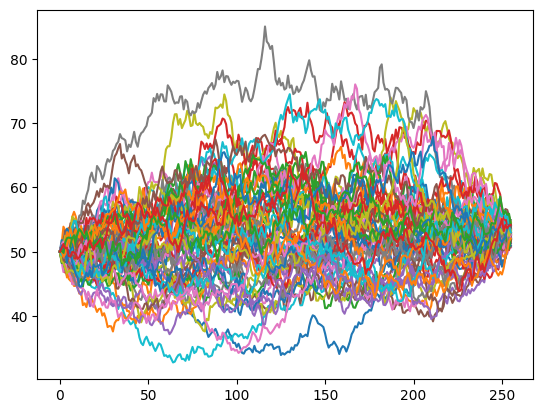

In [9]:
n_periods=int(2**8)
s0=S
expiry_T=T
return_rate=r
n_periods=int(2**8) #256
n_simulations=int(2**6) #64

n = int(np.log2(n_periods))
prices = np.zeros((n_periods, n_simulations))
prices = pd.DataFrame(prices)
prices.loc[0] = s0

for i in range(0, n_simulations):

    prices.loc[:,i] = s0*np.cumprod(1+return_rate*expiry_T/n_periods+sigma*brownian_bridge(w0=0, w1=0.0, n=n).W_t.diff().fillna(0).iloc[:-1].values)

# prices = pd.DataFrame(prices)
# prices.index.name = 'period'
# prices.index.columns = 'simulation'
# prices = prices.T

plt.plot(prices)
plt.show()

In [ ]:
prices = np.zeros((n_periods, n_simulations))
prices[0] = s0

for i in range(1, n_periods):

    prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*np.random.normal(loc=0.0, scale=1.0, size=n_simulations))

prices = pd.DataFrame(prices)
prices.index.name = 'period'
prices.index.columns = 'simulation'

In [ ]:
data = sobol_prices(s0=S, expiry_T=360, sigma=sigma,return_rate=r, n_periods=720, n_simulations=2**16).iloc[-1]
# bins = np.histogram(data, 
#                     bins=20)[1]

# bins = [float(x) for x in bins]

In [ ]:
n = 2**16

fx = [np.exp(-(x**2)/2)/np.sqrt(2*np.pi) for x in np.linspace(-3,3,n)]

x_lognorm = S*np.exp(r-(sigma*sigma)/2)*np.exp(np.linspace(-3,3,n)*sigma)
y_lognorm = fx
y_lognorm = y_lognorm/sum(np.diff(x_lognorm)*y_lognorm[1:])

fig, ax = plt.subplots()
sns.histplot(data,
             stat='density',
             bins=5000,
             ax=ax)

sns.lineplot(ax=ax,
             x=x_lognorm,
             y=y_lognorm,
             color='red')

In [ ]:
fx = [np.exp(-(x**2)/2)/np.sqrt(2*np.pi) for x in np.linspace(-4,4,200)]

In [ ]:
sobol_prices.iloc[-1]

In [ ]:
prices = prices.loc[:,[x//2 if x%2 == 0 else x//2+int(n_simulations/2) for x in range(0, n_simulations)]]
prices.columns = range(0,n_simulations)

In [ ]:
call_price_sobol(s0=S, strike_E=K, expiry_T=360, sigma=sigma, risk_free=r, n_periods=360, n_simulations=int(2**16))[1]

In [ ]:
x, y = call_price_anti(s0=S, strike_E=K, expiry_T=360, sigma=sigma, risk_free=r, n_periods=360, n_simulations=int(2**16))

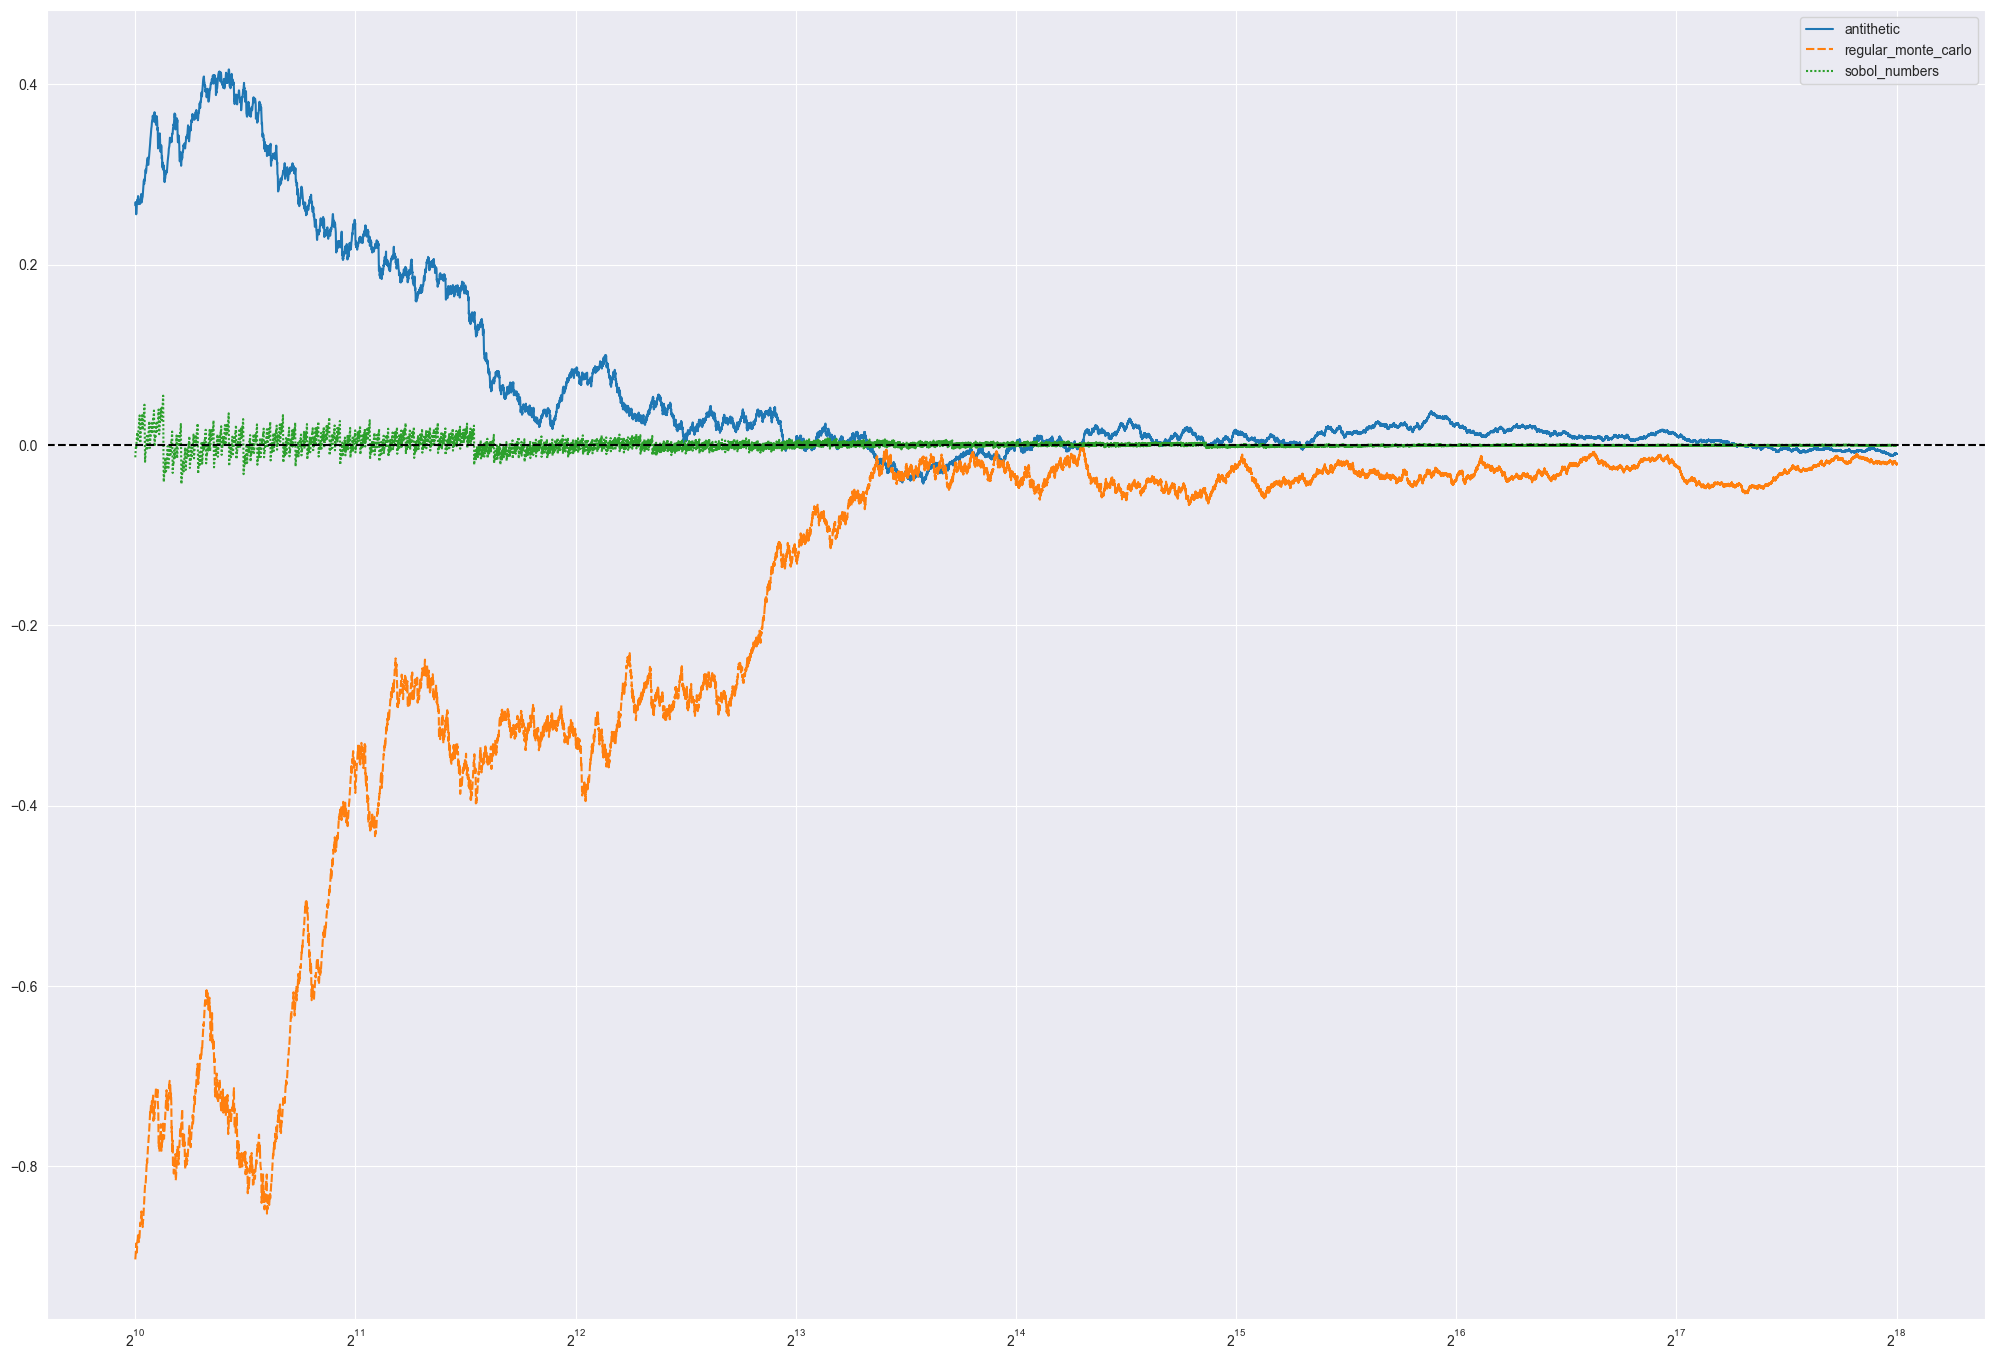

antithetic            -0.009843
regular_monte_carlo   -0.021642
sobol_numbers         -0.000026
Name: 262143, dtype: float64


In [289]:
bs_price = black_scholes(S, K, sigma, T, r)

df_mc_errors = pd.DataFrame(columns=['antithetic', 'regular_monte_carlo', 'sobol_numbers'])

n_simulations = 2**18
n_periods = 2**9

df_mc_errors['regular_monte_carlo'] = bs_price - pd.Series(call_price(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]).expanding().mean()
df_mc_errors['antithetic'] = bs_price - pd.Series(call_price_anti(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]).expanding().mean()
df_mc_errors['sobol_numbers'] = bs_price - call_price_sobol(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1].expanding().mean()

fig, ax = plt.subplots(figsize=(25, 17))

sns.lineplot(df_mc_errors.loc[1024:], 
             ax=ax)

plt.axhline(y=0.0, color='black', linestyle='--')
ax.set_xscale('log', base=2)
plt.show()

print(df_mc_errors.iloc[-1])


In [293]:
delta_s = 3.0
delta_T = 1/360

C0 = call_price_sobol(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[0]
C1 = call_price_sobol(s0=S+delta_s, strike_E=K, expiry_T=T-delta_T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[0]

In [ ]:
print(C0)
print(C1)

In [290]:
def delta_option(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations, shift_s0):

    C_plus = call_price_sobol(s0 + shift_s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations)[0]
    C_minus = call_price_sobol(s0 - shift_s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations)[0]

    return (C_plus-C_minus)/(2*shift_s0)

In [291]:
delta = delta_option(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations),shift_s0=1.0)

In [ ]:
sampler = scipy.stats.qmc.Sobol(d=1)
sample = sampler.random_base2(9)
norm.ppf(sample)

In [ ]:
from scipy.stats import qmc
from scipy import stats

In [ ]:
def sobol_norm(m, d=720):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

sobol_norm(18)

2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

In [ ]:
S = 50
K = 55
sigma_i = .30
sigma_a = .40

r = .1
T = 1 #in years

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

print(V_a-V_i)

In [ ]:
black_scholes(S, K, sigma_i, T, r)

In [ ]:
r=.1
T=3
sigma = .10

S*np.exp((r-(sigma*sigma)/2)*T)

In [ ]:
df_foo = euler_maruyama(s0=S, expiry_T=T, sigma=sigma, return_rate=r, n_periods=1000, n_simulations=5000)

df_foo.iloc[-1].mean()

In [ ]:
n_periods = 10000
T = 2

path_foo = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=1).iloc[:,0]
path_foo = path_foo.to_frame(name='Stock_Price')

#path_foo = path_foo.to_frame(name='Stock_Price')

path_foo['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
path_foo['Call_Delta_i'] = [bs_delta(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
path_foo['Call_Delta_a'] = [bs_delta(S=s, K=K, sigma=sigma_a, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]

path_foo['Call_Carry'] = [-V_i*r*t*T/n_periods for t in path_foo.index]
path_foo['Call_PnL'] = path_foo['Call_Price'] - path_foo.loc[0,'Call_Price'] + path_foo['Call_Carry']

path_foo['Cash_Position'] = [0.0]*len(path_foo)
path_foo['Cash_Rebalance'] = [0.0]*len(path_foo)
path_foo['Daily_Interest'] = [0.0]*len(path_foo)

path_foo['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma_a, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
path_foo.loc[0, 'Cash_Position'] = -path_foo.loc[0, 'Call_Delta_a']*path_foo.loc[0, 'Stock_Price']

path_foo['Ptf_Stock'] = path_foo['#_Stocks']*path_foo['Stock_Price']
path_foo['Cash_Rebalance'] = -path_foo['#_Stocks'].diff().fillna(0)*path_foo['Stock_Price']

for i in path_foo.index[1:]:

    path_foo.loc[i, 'Daily_Interest'] = path_foo.loc[i-1, 'Cash_Position']*r*T/n_periods
    path_foo.loc[i, 'Cash_Position'] = path_foo.loc[i-1, 'Cash_Position'] + path_foo.loc[i, 'Cash_Rebalance'] + path_foo.loc[i, 'Daily_Interest']

path_foo['Ptf_Total'] = path_foo['Cash_Position'] + path_foo['Ptf_Stock']

plt.plot(path_foo['Call_PnL'] - path_foo['Ptf_Total'])

In [ ]:
np.exp(r*T/n_periods)

In [ ]:
def delta_hedged_ptf(stock_path, K, T, sigma, r):

    df_hedged_ptf = pd.DataFrame(columns=['Cash_Position', 'Cash_Rebalance', 'Daily_Interest', '#_Stocks', 'Ptf_Stock', 'Ptf_Total'],
                                 index=range(0,len(stock_path)))
    
    
    s0 = stock_path[0]
    n_periods = len(stock_path)
    
    df_hedged_ptf['Cash_Position'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Cash_Rebalance'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Daily_Interest'] = [0.0]*len(df_hedged_ptf)

    df_hedged_ptf['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_hedged_ptf.index, stock_path)]
    df_hedged_ptf.loc[0, 'Cash_Position'] = -df_hedged_ptf.loc[0, '#_Stocks']*s0

    df_hedged_ptf['Ptf_Stock'] = df_hedged_ptf['#_Stocks']*stock_path
    df_hedged_ptf['Cash_Rebalance'] = -df_hedged_ptf['#_Stocks'].diff().fillna(0)*stock_path

    for i in df_hedged_ptf.index[1:]:

        df_hedged_ptf.loc[i, 'Daily_Interest'] = df_hedged_ptf.loc[i-1, 'Cash_Position']*r*T/n_periods
        df_hedged_ptf.loc[i, 'Cash_Position'] = df_hedged_ptf.loc[i-1, 'Cash_Position'] + df_hedged_ptf.loc[i, 'Cash_Rebalance'] + df_hedged_ptf.loc[i, 'Daily_Interest']

    df_hedged_ptf['Ptf_Total'] = df_hedged_ptf['Cash_Position'] + df_hedged_ptf['Ptf_Stock']

    return df_hedged_ptf


def call_ptf(stock_path, K, T,sigma, r):

    s0 = stock_path[0]
    n_periods = len(stock_path)

    V_i = black_scholes(S=s0, K=K, sigma=sigma, T=T, r=r)

    df_call_ptf = pd.DataFrame(columns=['Call_Price', 'Call_Carry', 'Call_PnL'],
                               index=range(0,len(stock_path)))

    df_call_ptf['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Carry'] = [V_i*(1-np.exp(r*T*t/n_periods)) for t in df_call_ptf.index]
    df_call_ptf['Call_PnL'] = df_call_ptf['Call_Price'] - df_call_ptf.loc[0,'Call_Price'] + df_call_ptf['Call_Carry']
    
    df_call_ptf['Call_Delta'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Gamma'] = [bs_gamma(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Theta'] = [bs_theta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    
    df_call_ptf['Call_Rho'] = [bs_rho(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Vega'] = [bs_vega(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]

    df_call_ptf['PnL_Delta'] = (df_call_ptf['Call_Delta'].shift(1)*stock_path.diff()).cumsum()
    df_call_ptf['PnL_Gamma'] = (df_call_ptf['Call_Gamma'].shift(1)*np.square(stock_path.diff())).cumsum()/2
    df_call_ptf['PnL_Theta'] = (df_call_ptf['Call_Theta'].shift(1)*T/n_periods).cumsum()
    df_call_ptf['PnL_Carry'] = df_call_ptf['Call_Carry']

    df_call_ptf['PnL_Greeks'] = df_call_ptf[['PnL_Delta','PnL_Gamma','PnL_Theta','PnL_Carry']].sum(axis=1)

    return df_call_ptf

    

In [ ]:
T = 4.0

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

n_periods = 10000

df_price_paths = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=5)

for i in df_price_paths.columns:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r).Ptf_Total

    plt.plot(df_call - df_ptf)

plt.axhline(y=np.exp(r*T)*(V_a-V_i), color='black', linestyle='--')


3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is\
the impact of time-dependent Gamma $ \Gamma_{t} $? <br> What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

In [ ]:
stock_path = df_price_paths.loc[:, i]

df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r)
df_ptf = -delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r)

df_total = df_call.merge(df_ptf, right_index=True, left_index=True)

df_total['PnL_Total'] = df_total[['Call_PnL','Ptf_Total']].sum(axis=1)
df_total['PnL_Delta_Total'] = df_total.PnL_Delta + df_total.Ptf_Stock.diff(1).cumsum() + df_total.Cash_Rebalance.cumsum()
df_total['Total_Carry'] = df_total['PnL_Carry'] + df_total['Daily_Interest'].cumsum()


df_total[['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']].plot()

for col in ['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']:
    
    plt.annotate('%.2f' % df_total[col].iloc[-1], xy=(n_periods, df_total[col].iloc[-1]))

plt.show()

## Part II: Minimum Variance Delta

1. begin with sorting your IV data – or each trading day, you will need BS option price as
implied vol percentage, delta, and vega: ($ V_{t} $,$ \delta_{bs} $,$ \nu_{bs} $). <br> 
The term structure for option expiry $ 1M, 3M, 6M, 9M, 12M $, weekly expiries not necessary. <br> 
Key choice to make here, if
you are going to study Delta for out of the money call strikes, in addition to about ATM
buckets $ 0.45 < \delta_{bs} <0.55 $ – each strike means a separate a,b,c history for each expiry.

2. compute your dependent variable and run the fitting on $ \delta_{bs} $,$ \delta^2_{bs} $. <br>Dependent side based
on daily option price changes $ \Delta V_{t} $, and you will need $( \Delta S_{t} , S_{t}) $ as well as Greeks noted
above. <br> The exact data columns will depend on how you organise regression or do SLSQP.

In [ ]:
csv_files = sorted(os.listdir('spx_eod_data'))

df_option_data = pd.DataFrame()

for file in csv_files[:36]:

    df_option_data = pd.concat([df_option_data,
                                pd.read_csv(filepath_or_buffer=f'spx_eod_data/{file}')
                                ])

# df_option_data = pd.read_csv(filepath_or_buffer='spx_eod_data/spx_eod_201001.txt')

#Parse Data
df_option_data.columns = [x.strip().replace('[','').replace(']','') for x in df_option_data.columns]
df_option_data['QUOTE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.QUOTE_DATE]
df_option_data['EXPIRE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.EXPIRE_DATE]

#df_option_data = df_option_data[[not((df_option_data.loc[x]==' ').any()) for x in df_option_data.index]]
df_option_data = df_option_data.replace(' ', np.nan)
df_option_data = df_option_data[~df_option_data.isna().any(axis=1)]
df_option_data = df_option_data.loc[df_option_data.DTE > 14]

for col in ['C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST', 'C_BID', 
            'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
            'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT']:
    
    df_option_data[col] = [float(x) for x in df_option_data[col]]


In [ ]:
df_option_data.columns[[8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28]]

In [ ]:
#Parse data for CALLS

df_calls_data = df_option_data.drop(['P_BID', 'P_ASK', 'P_SIZE', 'P_LAST', 'P_DELTA', 
                                     'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV','P_VOLUME'], axis=1)

df_calls_data = df_calls_data[(df_calls_data.C_DELTA < .95)&(df_calls_data.C_DELTA > .05)]
df_calls_data['BS_Delta_Bucket'] = [round(x*10)/10 for x in df_calls_data.C_DELTA]

df_calls_data['Expiry_Bucket'] = pd.cut(df_calls_data.DTE,[14,30,91, 182,365,2000],
                                        labels=['1M', '3M', '6M', '9M', '12M'])

df_calls_data = df_calls_data.set_index(['BS_Delta_Bucket','Expiry_Bucket'])

In [ ]:
df_calls_data

In [ ]:
df_foo = df_calls_data.loc[(.5,'6M')]

df_foo = df_foo.groupby('QUOTE_DATE')[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE']].mean()

df_foo['Delta_S'] = df_foo['UNDERLYING_LAST'].diff()/df_foo['UNDERLYING_LAST']
df_foo['Delta_IV'] = df_foo['C_IV'].diff()

df_foo = df_foo.dropna()

x = df_foo['Delta_IV']
y = df_foo['Delta_S']

slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = df_foo['Delta_IV'],
            y = df_foo['Delta_S'])

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Log Std Deviation of Prices vs Log Simulations: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
df_foo = df_calls_data.loc[(.5,'12M')]

df_foo = df_foo.groupby('QUOTE_DATE')[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE']].mean()

df_foo['Delta_S'] = df_foo['UNDERLYING_LAST'].diff()/df_foo['UNDERLYING_LAST']
df_foo['Delta_IV'] = df_foo['C_IV'].diff()

df_foo = df_foo.dropna()

x = df_foo['Delta_IV']
y = df_foo['Delta_S']

slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Asset Price vs Change in Implied Vol: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

x = (df_foo['UNDERLYING_LAST'].diff()*df_foo['C_DELTA']).dropna()
y = df_foo['C_LAST'].diff().dropna()


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Option Price vs PnL Delta: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
df_foo2 = df_calls_data.xs('6M', level=1)

df_foo2 = df_foo2.groupby(['BS_Delta_Bucket','QUOTE_DATE'])[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE']].mean()

list_slopes = []

for delta_bucket in df_foo2.index.get_level_values(0).unique():

    df_loop = df_foo2.loc[delta_bucket]
    df_loop['Delta_S'] = df_loop['UNDERLYING_LAST'].diff()/df_loop['UNDERLYING_LAST']
    
    df_loop['Delta_IV'] = df_loop['C_IV'].diff()

    df_loop = df_loop.dropna()

    x = df_loop['Delta_IV']
    y = df_loop['Delta_S']

    slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
    fitted_data = list(map(fitted_line, x))

    # plt.scatter(x = df_loop['Delta_IV'],
    #             y = df_loop['Delta_S'])

    # plt.plot(x, fitted_data)

    # plt.show()
    list_slopes.append(slope)
    # print(f"""Linear Regression - Log Std Deviation of Prices vs Log Simulations: \n
    #     Slope:{slope}\n
    #     Intercept:{intercept}\n  
    #     R²: {r**2}""")
    
    # print(delta_bucket)


In [ ]:
list_slopes = np.sqrt(df_foo2.groupby('BS_Delta_Bucket')['DTE'].mean().values/360)*list_slopes

x = df_foo2.index.get_level_values(0).unique()
y = list_slopes

model = np.poly1d(np.polyfit(x, y, 2))

#add fitted polynomial line to scatterplot
plt.scatter(x, y)
plt.plot(x, model(x))

print(model)
plt.show()



In [ ]:
for i in df_foo2.index.get_level_values(0).unique():

    df_foo2.loc[i]

In [ ]:
i = .5

In [ ]:
df_foo2.loc[i].C_DELTA.shift()

In [ ]:
plt.plot(df_foo2.loc[i].UNDERLYING_LAST.diff()*df_foo2.loc[i].C_DELTA)
plt.plot(df_foo2.loc[i].C_LAST.diff())

In [ ]:
df_foo2.loc[i].C_LAST.diff()

In [ ]:
y

#### $ \Delta f - \delta_{bs}\Delta S = \frac{\nu_{bs}}{\sqrt{T}}\frac{\Delta S}{S}(a+b\delta_{bs}+\delta^{2}_{bs}) $

In [ ]:
df_foo2.loc[i,'UNDERLYING_LAST'].diff()*df_foo2.loc[i,'C_VEGA']/(np.sqrt(df_foo2.loc[i,'DTE'])*df_foo2.loc[i,'UNDERLYING_LAST'])

In [ ]:
x = (df_foo2.loc[i]['UNDERLYING_LAST'].diff()*df_foo2.loc[i]['C_DELTA']).dropna()
y = df_foo2.loc[i]['C_LAST'].diff().dropna()


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Option Price vs PnL Delta: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

data = (x-y).values
bins = 30

bins = np.histogram(data, 
                    bins=30)[1]

bins = [float(x) for x in bins]


fig, ax = plt.subplots(figsize=(25,16))

sns.histplot(data,stat='density',
                bins=30,
                ax=ax)

sns.lineplot(ax=ax,
             x=bins,
             y=gaussian(data=data,
                        bins=bins),
            color='red')


textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(data), ),
    r'$\mathrm{median}=%.2f$' % (np.median(data), ),
    r'$\sigma=%.2f$' % (np.std(data), ),
    r'$\frac{\sigma}{\mu}=%.2f$'% (np.std(data)*100/np.mean(data), )+'%'))

ax.text(0.1, 0.95, textstr, 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            bbox=props)

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

data = (x).values
bins = 30

bins = np.histogram(data, 
                    bins=30)[1]

bins = [float(x) for x in bins]


fig, ax = plt.subplots(figsize=(25,16))

sns.histplot(data,stat='density',
                bins=30,
                ax=ax)

sns.lineplot(ax=ax,
             x=bins,
             y=gaussian(data=data,
                        bins=bins),
            color='red')


textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(data), ),
    r'$\mathrm{median}=%.2f$' % (np.median(data), ),
    r'$\sigma=%.2f$' % (np.std(data), ),
    r'$\frac{\sigma}{\mu}=%.2f$'% (np.std(data)*100/np.mean(data), )+'%'))

ax.text(0.1, 0.95, textstr, 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            bbox=props)